In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torchvision.models as models
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import os
import copy
import random
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm

random.seed(42)
np.random.seed(42)

### Preprocessing

In [ ]:
img_size = 224

preprocess_classification = T.Compose([
    T.Resize((img_size, img_size)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],   # ImageNet mean
                std=[0.229, 0.224, 0.225])    # ImageNet std
])

### Augmentation

In [4]:
train_transforms_classification = T.Compose([
    T.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(15),
    T.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.02
    ),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

valid_test_transforms_classification = preprocess_classification

In [5]:
classifn_path = "datasets/classification_dataset"

train_dataset = ImageFolder(root=os.path.join(classifn_path, "train"),
                            transform=train_transforms_classification)

valid_dataset = ImageFolder(root=os.path.join(classifn_path, "valid"),
                            transform=valid_test_transforms_classification)

test_dataset  = ImageFolder(root=os.path.join(classifn_path, "test"),
                            transform=valid_test_transforms_classification)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

dataloaders = {"train": train_loader, "val": valid_loader}
dataset_sizes = {"train": len(train_dataset), "val": len(valid_dataset)}
class_names = train_dataset.classes

### Model

In [6]:
class CustomCNN(nn.Module):
    def __init__(self, img_size, num_classes=2):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (img_size//8) * (img_size//8), 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
# transfer learning
def get_resnet_model(num_classes=2):
    model = models.resnet50(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False  # freeze base layers
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)  # replace final layer
    return model

In [7]:
# early stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            min_delta (float): Minimum improvement needed to count as progress.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return
        
        if val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(img_size=224, num_classes=len(class_names))
model = model.to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

### Training

#### Custom CNN

In [10]:
# custom model

num_epochs = 20
checkpoint_path = "saved_models/customcnn.pt"
os.makedirs("saved_models", exist_ok=True)

early_stopper = EarlyStopping(patience=7, min_delta=0.0005)
best_val_loss = float("inf")
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == "train":
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f"{phase} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

        if phase == "train":
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc.item())
        else:
            val_losses.append(epoch_loss)
            val_accs.append(epoch_acc.item())

            # model checkpoint
            if epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                torch.save(model.state_dict(), checkpoint_path)
                print(f"Model improved & saved at {checkpoint_path}")

            # early stopping
            early_stopper(epoch_loss)
            if early_stopper.early_stop:
                print("Early stopping triggered!")
                break

    if early_stopper.early_stop:
        break

print("Training completed")
print(f"Best validation loss: {best_val_loss:.4f}")


Epoch 1/20
train Loss: 0.6000  Acc: 0.6784
val Loss: 0.6188  Acc: 0.6290
Model improved & saved at saved_models/customcnn.pt

Epoch 2/20
train Loss: 0.5141  Acc: 0.7494
val Loss: 0.4798  Acc: 0.7602
Model improved & saved at saved_models/customcnn.pt

Epoch 3/20
train Loss: 0.4633  Acc: 0.7761
val Loss: 0.4915  Acc: 0.7489

Epoch 4/20
train Loss: 0.4305  Acc: 0.8069
val Loss: 0.4281  Acc: 0.8054
Model improved & saved at saved_models/customcnn.pt

Epoch 5/20
train Loss: 0.4024  Acc: 0.8110
val Loss: 0.4362  Acc: 0.8032

Epoch 6/20
train Loss: 0.3841  Acc: 0.8325
val Loss: 0.4260  Acc: 0.8054
Model improved & saved at saved_models/customcnn.pt

Epoch 7/20
train Loss: 0.3698  Acc: 0.8415
val Loss: 0.4185  Acc: 0.8077
Model improved & saved at saved_models/customcnn.pt

Epoch 8/20
train Loss: 0.3545  Acc: 0.8467
val Loss: 0.4202  Acc: 0.8258

Epoch 9/20
train Loss: 0.3345  Acc: 0.8546
val Loss: 0.3945  Acc: 0.8190
Model improved & saved at saved_models/customcnn.pt

Epoch 10/20
train Los

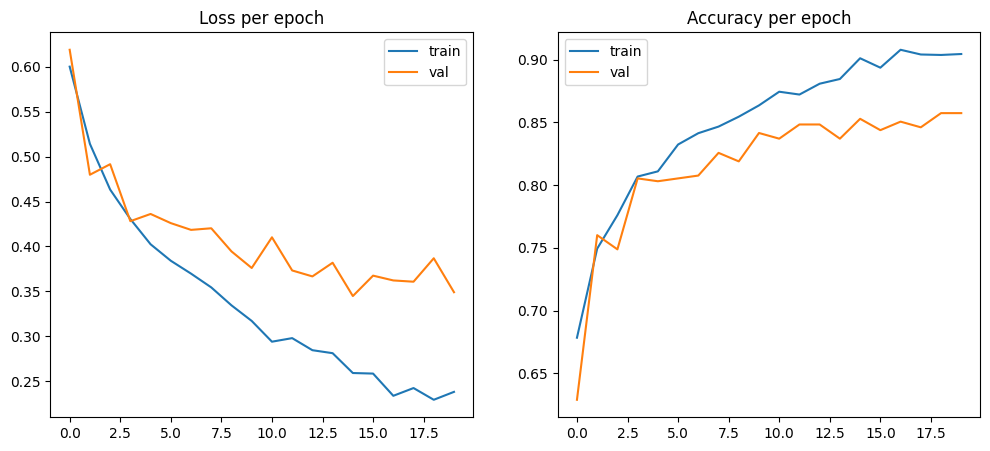

In [11]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.title("Loss per epoch")
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label="train")
plt.plot(val_accs, label="val")
plt.title("Accuracy per epoch")
plt.legend()
plt.show()

#### ResNet

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelt = get_resnet_model(num_classes=len(class_names))
modelt = modelt.to(device)

In [ ]:
# resnet
num_epochs = 20
best_model_wts = copy.deepcopy(modelt.state_dict())
best_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # each epoch has a training and validation phase
    for phase in ["train", "val"]:
        if phase == "train":
            modelt.train()
        else:
            modelt.eval()
        
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in tqdm(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == "train"):
                outputs = modelt(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                if phase == "train":
                    loss.backward()
                    optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        
        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        
        if phase == "train":
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc.item())
        else:
            val_losses.append(epoch_loss)
            val_accs.append(epoch_acc.item())
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

Epoch 1/20


100%|██████████| 84/84 [02:20<00:00,  1.68s/it]


train Loss: 0.5378 Acc: 0.7802


100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


val Loss: 0.3601 Acc: 0.9299
Epoch 2/20


100%|██████████| 84/84 [02:11<00:00,  1.56s/it]


train Loss: 0.3389 Acc: 0.9211


100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


val Loss: 0.2639 Acc: 0.9367
Epoch 3/20


100%|██████████| 84/84 [02:13<00:00,  1.58s/it]


train Loss: 0.2645 Acc: 0.9328


100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


val Loss: 0.2193 Acc: 0.9367
Epoch 4/20


100%|██████████| 84/84 [02:12<00:00,  1.57s/it]


train Loss: 0.2266 Acc: 0.9418


100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


val Loss: 0.1936 Acc: 0.9457
Epoch 5/20


100%|██████████| 84/84 [02:14<00:00,  1.60s/it]


train Loss: 0.2012 Acc: 0.9493


100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


val Loss: 0.1762 Acc: 0.9412
Epoch 6/20


100%|██████████| 84/84 [02:12<00:00,  1.58s/it]


train Loss: 0.1774 Acc: 0.9519


100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


val Loss: 0.1636 Acc: 0.9434
Epoch 7/20


100%|██████████| 84/84 [02:13<00:00,  1.59s/it]


train Loss: 0.1776 Acc: 0.9489


100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


val Loss: 0.1545 Acc: 0.9480
Epoch 8/20


100%|██████████| 84/84 [02:14<00:00,  1.60s/it]


train Loss: 0.1666 Acc: 0.9504


100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


val Loss: 0.1479 Acc: 0.9502
Epoch 9/20


100%|██████████| 84/84 [02:14<00:00,  1.60s/it]


train Loss: 0.1518 Acc: 0.9542


100%|██████████| 14/14 [00:23<00:00,  1.64s/it]


val Loss: 0.1421 Acc: 0.9480
Epoch 10/20


100%|██████████| 84/84 [02:09<00:00,  1.54s/it]


train Loss: 0.1443 Acc: 0.9576


100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


val Loss: 0.1389 Acc: 0.9480
Epoch 11/20


100%|██████████| 84/84 [02:13<00:00,  1.59s/it]


train Loss: 0.1462 Acc: 0.9485


100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


val Loss: 0.1391 Acc: 0.9480
Epoch 12/20


100%|██████████| 84/84 [02:12<00:00,  1.57s/it]


train Loss: 0.1394 Acc: 0.9557


100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


val Loss: 0.1318 Acc: 0.9480
Epoch 13/20


100%|██████████| 84/84 [02:13<00:00,  1.59s/it]


train Loss: 0.1326 Acc: 0.9564


100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


val Loss: 0.1305 Acc: 0.9480
Epoch 14/20


100%|██████████| 84/84 [02:15<00:00,  1.61s/it]


train Loss: 0.1285 Acc: 0.9576


100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


val Loss: 0.1274 Acc: 0.9548
Epoch 15/20


100%|██████████| 84/84 [02:13<00:00,  1.59s/it]


train Loss: 0.1272 Acc: 0.9587


100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


val Loss: 0.1214 Acc: 0.9480
Epoch 16/20


100%|██████████| 84/84 [02:09<00:00,  1.54s/it]


train Loss: 0.1320 Acc: 0.9572


100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


val Loss: 0.1258 Acc: 0.9480
Epoch 17/20


100%|██████████| 84/84 [02:13<00:00,  1.59s/it]


train Loss: 0.1203 Acc: 0.9647


100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


val Loss: 0.1230 Acc: 0.9525
Epoch 18/20


100%|██████████| 84/84 [02:08<00:00,  1.53s/it]


train Loss: 0.1200 Acc: 0.9636


100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


val Loss: 0.1157 Acc: 0.9548
Epoch 19/20


100%|██████████| 84/84 [02:11<00:00,  1.57s/it]


train Loss: 0.1151 Acc: 0.9628


100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


val Loss: 0.1146 Acc: 0.9525
Epoch 20/20


100%|██████████| 84/84 [02:12<00:00,  1.57s/it]


train Loss: 0.1200 Acc: 0.9579


100%|██████████| 14/14 [00:22<00:00,  1.61s/it]

val Loss: 0.1160 Acc: 0.9525


In [ ]:
modelt.load_state_dict(best_model_wts)

<All keys matched successfully>

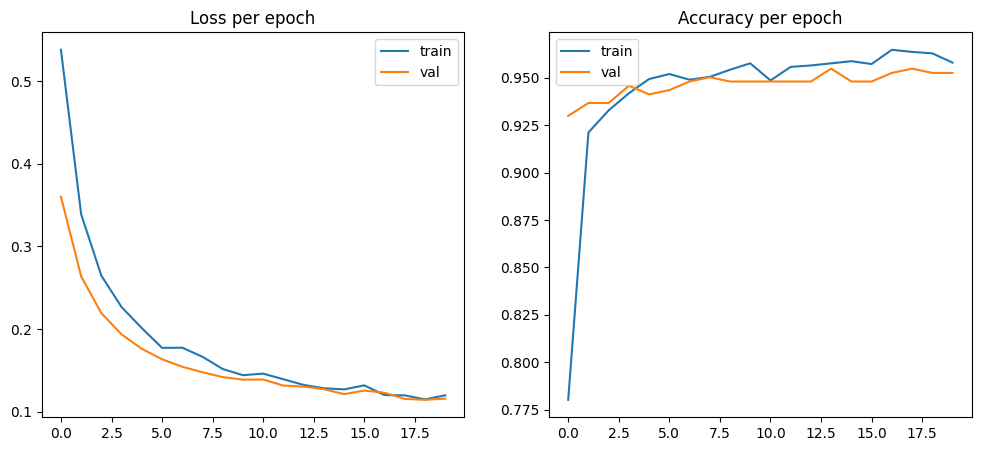

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.title("Loss per epoch")
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label="train")
plt.plot(val_accs, label="val")
plt.title("Accuracy per epoch")
plt.legend()
plt.show()


### Evaluation

#### Custom CNN

In [12]:
model.eval()
all_preds = []
all_labels = []

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

        bird       0.89      0.89      0.89       121
       drone       0.86      0.86      0.86        94

    accuracy                           0.88       215
   macro avg       0.88      0.88      0.88       215
weighted avg       0.88      0.88      0.88       215



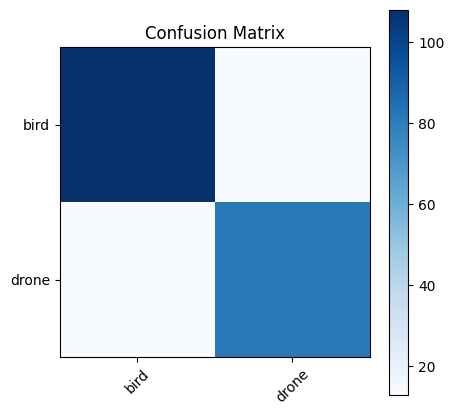

In [13]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,5))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)
plt.show()

#### ResNet

In [ ]:
modelt.eval()
all_predst = []
all_labelst = []

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = modelt(inputs)
        _, preds = torch.max(outputs, 1)
    all_predst.extend(preds.cpu().numpy())
    all_labelst.extend(labels.cpu().numpy())

print("Classification Report:\n")
print(classification_report(all_labelst, all_predst, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

        bird       0.96      0.96      0.96       121
       drone       0.95      0.95      0.95        94

    accuracy                           0.95       215
   macro avg       0.95      0.95      0.95       215
weighted avg       0.95      0.95      0.95       215



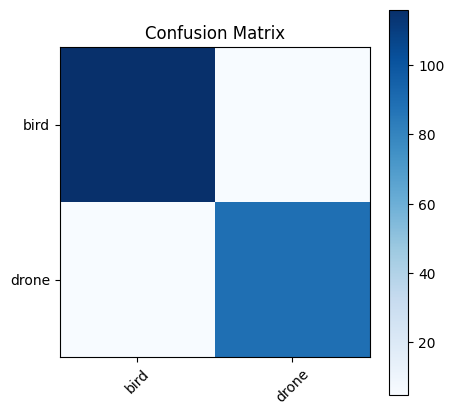

In [ ]:
cm = confusion_matrix(all_labelst, all_predst)
plt.figure(figsize=(5,5))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)
plt.show()

The ResNet model performs the best at 20 epochs with 95% accuracy and is faster.

In [ ]:
os.makedirs("saved_models", exist_ok=True)
torch.save(model.state_dict(), "saved_models/resnet_classification_model.pt")
print("Model saved at saved_models/resnet_classification_model.pt")

Model saved at saved_models/resnet_classification_model.pt
